# EDA and Feature Engineering for Meta Data
## Import necessary libraries

In [1]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [2]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pickle.load(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(403, 57)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged,GDP_date,GDP_value,...,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1,1982-04-01,6825.876,...,42.307692,7.755145,4.956703,7.756494,-2.244855,-5.043297,-2.243506,NaN,NaN,NaN
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1,1982-07-01,6799.781,...,34.831461,6.712675,3.321878,7.576718,-2.787325,-6.178122,-1.923282,-1.042471,-1.634825,-0.179776
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,...,45.026178,6.774240,3.383443,6.717484,-1.725760,-5.116557,-1.782516,0.061565,0.061565,-0.859235
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,...,14.004376,6.435818,3.045021,6.768247,-2.064182,-5.454979,-1.731753,-0.338422,-0.338422,0.050763
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,0,1982-07-01,6799.781,...,14.004376,6.435818,3.045021,6.768247,-2.064182,-5.454979,-1.731753,0.000000,0.000000,0.000000


In [3]:
# Load nontext moving average data
file = open('../data/preprocessed/nontext_ma2.pickle', 'rb')
nontext_ma2 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma3.pickle', 'rb')
nontext_ma3 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma6.pickle', 'rb')
nontext_ma6 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma12.pickle', 'rb')
nontext_ma12 = pickle.load(file)
file.close()

# EDA on nontext dataset

In [4]:
# Add previous rate decision to see inertia effect
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

,RateDecision,prev_decision,next_decision
date,,,
1982-10-05,-1,<NA>,-1
1982-11-16,-1,-1,0
1982-12-21,0,-1,0
1983-01-14,0,0,0
1983-01-21,0,0,0


In [5]:
# # Take the same period as text dataset (--> Removed as it is determined later)
# nontext_data = nontext_data.loc[nontext_data.index > dt.datetime(1994,1,1)]
# nontext_ma2 = nontext_ma2.loc[nontext_ma2.index > dt.datetime(1994,1,1)]
# nontext_ma3 = nontext_ma3.loc[nontext_ma3.index > dt.datetime(1994,1,1)]
# nontext_ma6 = nontext_ma6.loc[nontext_ma6.index > dt.datetime(1994,1,1)]
# nontext_ma12 = nontext_ma12.loc[nontext_ma12.index > dt.datetime(1994,1,1)]

In [6]:
nontext_data.describe()

,Rate,RateDiff,RateDecision,RateChanged,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_value,GDPPOT_diff_prev,GDPPOT_diff_year,...,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff,prev_decision,next_decision
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,...,4.030000e+02,403.000000,403.000000,403.000000,4.030000e+02,402.000000,402.000000,402.000000,402.000000,402.000000
mean,4.008375,-0.024194,-0.017370,0.339950,12621.710025,0.609217,2.525297,12820.825112,0.648260,2.640109,...,3.295752e+00,2.933847,-0.091613,-0.737436,-1.099341e+00,-0.015520,-0.012330,-0.019295,-0.017413,-0.014925
std,3.094272,0.236367,0.583518,0.474281,3611.444378,0.984542,2.117550,3644.036210,0.205670,0.834630,...,1.980002e+00,2.412217,1.760743,2.039886,7.168520e-01,0.443883,0.431581,0.203352,0.584245,0.582176
min,0.000000,-1.000000,-1.000000,0.000000,6799.781000,-8.986117,-9.032775,7218.805705,0.285924,1.167859,...,6.661338e-15,-0.746424,-4.736113,-7.510053,-2.653405e+00,-4.741989,-3.137667,-1.073487,-1.000000,-1.000000
25%,1.000000,0.000000,0.000000,0.000000,9341.642000,0.364111,1.724359,9600.662063,0.456630,1.850198,...,2.077546e+00,0.602374,-1.466800,-1.822994,-1.571531e+00,-0.144640,-0.121559,-0.044613,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,12877.593000,0.631463,2.703335,12590.942406,0.648422,2.635164,...,3.421719e+00,3.063647,-0.238592,-0.553272,-1.115207e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,0.000000,0.000000,1.000000,15669.207500,0.969652,3.889400,16125.575168,0.811687,3.277348,...,4.623503e+00,4.575803,1.424211,0.157463,-5.055262e-01,0.119969,0.103027,0.033896,0.000000,0.000000
max,11.500000,1.125000,1.000000,1.000000,19253.959000,7.406283,8.578274,19267.720000,1.064666,4.299657,...,7.865083e+00,8.846595,4.390215,4.976162,1.942890e-16,3.848265,1.840636,0.680155,1.000000,1.000000


In [7]:
nontext_data.isnull().sum()

unscheduled           0
forecast              0
confcall              0
ChairPerson           0
Rate                  0
RateDiff              0
RateDecision          0
RateChanged           0
GDP_date              0
GDP_value             0
GDP_diff_prev         0
GDP_diff_year         0
GDPPOT_date           0
GDPPOT_value          0
GDPPOT_diff_prev      0
GDPPOT_diff_year      0
PCE_date              0
PCE_value             0
PCE_diff_prev         0
PCE_diff_year         0
CPI_date              0
CPI_value             0
CPI_diff_prev         0
CPI_diff_year         0
Unemp_date            0
Unemp_value           0
Unemp_diff_prev       0
Unemp_diff_year       0
Employ_date           0
Employ_value          0
Employ_diff_prev      0
Employ_diff_year      0
PMI_date              0
PMI_value             0
PMI_diff_prev         0
PMI_diff_year         0
NMI_date            281
NMI_value           281
NMI_diff_prev       281
NMI_diff_year       295
Rsales_date         116
Rsales_value    

Count: 
 0    266
-1     72
 1     65
Name: RateDecision, dtype: Int64
Percent: 
 0    66.0
-1    18.0
 1    16.0
Name: RateDecision, dtype: float64


Text(0.5, 1.0, 'nontext_data')

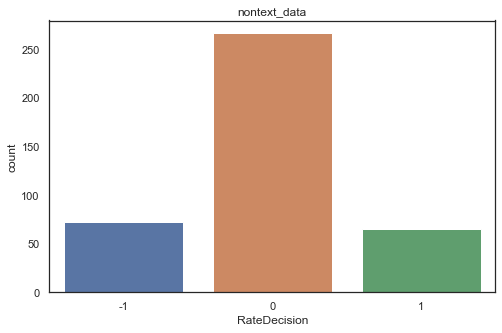

In [8]:
# The number of data per Target Labels
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

Highly imbalanced to 0 (hold), so need to consider this point. Always predicting 0 (hold) will result in the accuracy of more than 60%. 

## Correlation

In [9]:
nontext_data.columns.values

array(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'RateChanged', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date',
       'Employ_value', 'Employ_diff_prev', 'Employ_diff_year', 'PMI_date',
       'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 'NMI_date',
       'NMI_value', 'NMI_diff_prev', 'NMI_diff_year', 'Rsales_date',
       'Rsales_value', 'Rsales_diff_prev', 'Rsales_diff_year',
       'Hsales_date', 'Hsales_value', 'Hsales_diff_prev',
       'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia', 'Taylor-Rate',
       'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff',
       'Inertia_diff', 'prev_decision'

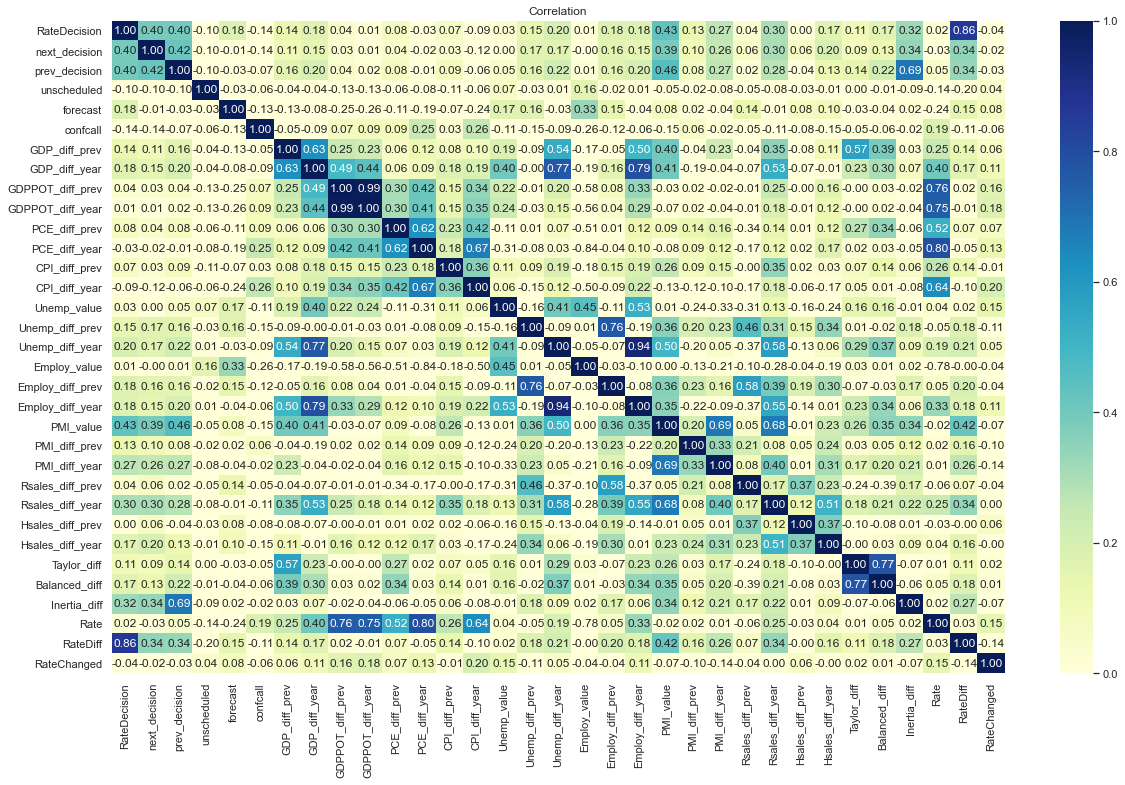

In [10]:
# Per document type
corr_columns = ['RateDecision', 'next_decision', 'prev_decision', 'unscheduled', 'forecast', 'confcall', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Rate', 'RateDiff', 'RateChanged']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

Observation on the correlation:

Higher correlation with Rate Decision:
 * 'GDP_diff_prev'
 * 'Unemp_diff_year'
 * 'Employ_diff_prev'
 * 'PMI_value'
 * 'Rsales_diff_year'
 * 'Hsales_diff_year'
 * 'prev_decision'
 * 'Taylor_diff'
 * 'Balanced_diff'
 * 'Inertia_diff'

Low correlation with Rate Decision:
 *  'unscheduled' - correlation is small
 * 'forecast' - logically not related
 * 'confcall' - correlation is small
 * 'GDP_diff_year' - use GDP_diff_prev instead, which highly correlate to this
 * 'GDPPOT_diff_prev' - correlation is small
 * 'GDPPOT_diff_year' - correlation is small
 * 'PCE_diff_prev' - correlation is small
 * 'PCE_diff_year' - correlation is small
 * 'CPI_diff_prev' - correlation is small
 * 'CPI_diff_year' - correlation is small
 * 'Unemp_value' - correlation is small
 * 'Unemp_diff_prev' - use Unemp_diff_year instead, which highly correlate to this
 * 'Employ_value' - correlation is small
 * 'Employ_diff_year' - use Employ_diff_prev instead, which highly correlate to this
 * 'PMI_diff_prev' - correlation is small
 * 'PMI_diff_year' - correlation is small
 * 'Rsales_diff_prev' - correlation is small
 * 'Rsales_diff_year' - correlation is small
 * 'Hsales_diff_prev' - correlation is small
 * 'Hsales_diff_year' - correlation is small
 * 'next_decision' - this was added to see whether there's any meaningful correlation from previous period

Will create two dataset, one full set and the other smaller set with high correlation

### Moving average

In [11]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

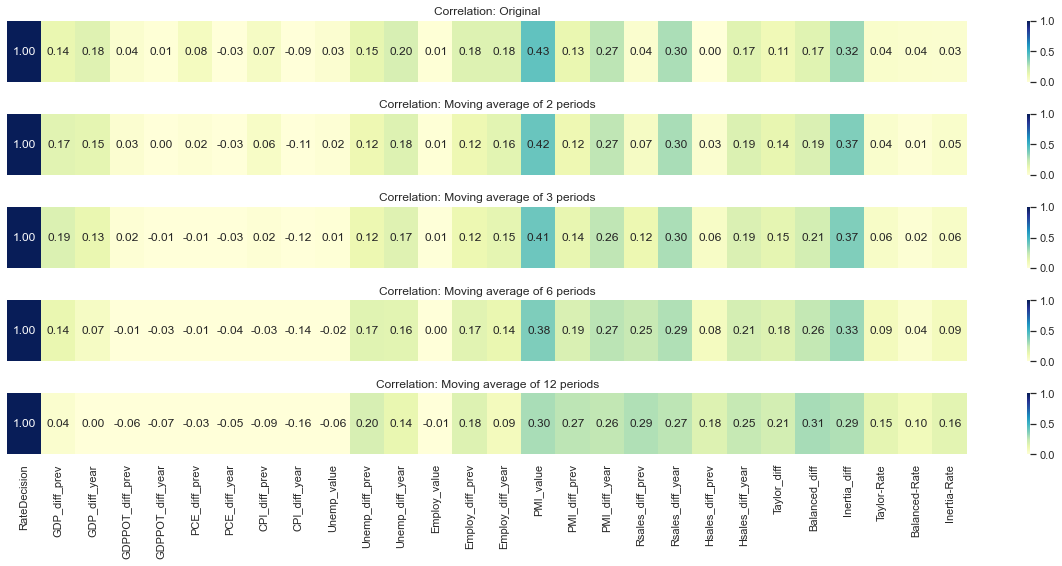

In [12]:
# Moving average (window = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))

sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])

fig.tight_layout(pad=1.0)
plt.show()


Not much improvement. The followings can be used:
 * Unemp_diff_prev for previous 3 period
 * Emp_diff_prev for previous 2 period
 * Rsales_diff_year for previous 2 period
 * Hsales_diff_year for previous 12 period
 * Balanced_diff for previous 12 period
 * Intertia_diff for previous 3 period

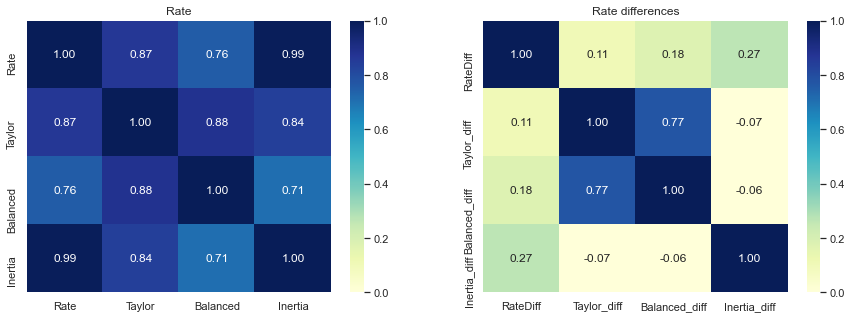

In [13]:
# Correlation between Taylor rule and actual rates are quite high

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

corr_columns = ['Rate', 'Taylor', 'Balanced', 'Inertia']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate")

corr_columns = ['RateDiff', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Rate differences")

plt.show()

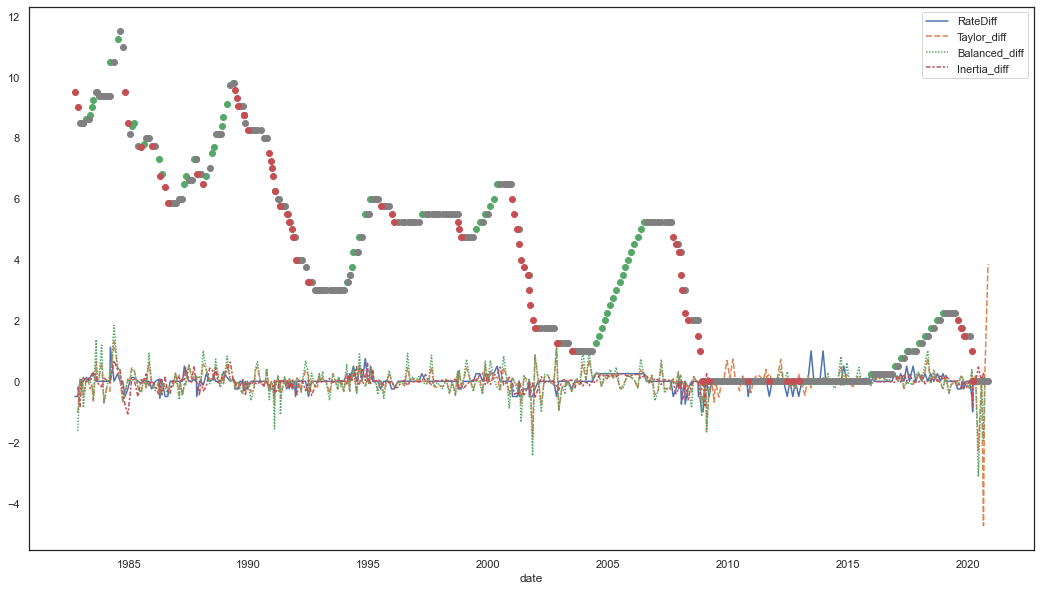

In [14]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)

decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]

ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")


### Check individual columns

In [15]:
def plot_distribution(df, columns):
    for col in columns:        
        fig, ax = plt.subplots(figsize=(10, 5))
        g = sns.kdeplot(df[col][(df["RateDecision"] == -1) & (df[col].notnull())], color="Red", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], ax=g, color="Blue", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], ax=g, color="Green", shade=True)
        g.set_xlabel(col)
        g.set_ylabel("Frequency")
        g.set_title("Distribution for " + col, fontsize=14)
        g = g.legend(["Lower", "Hold", "Raise"])
        
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map(sns.distplot, col)


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

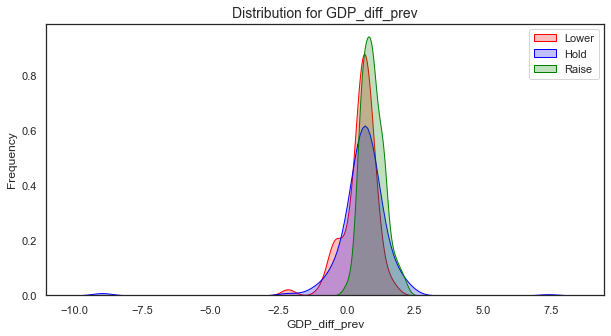

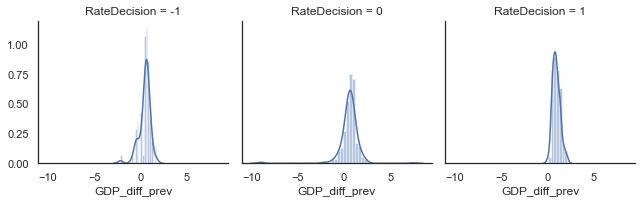

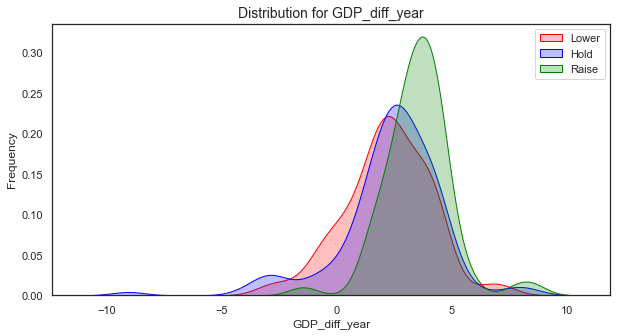

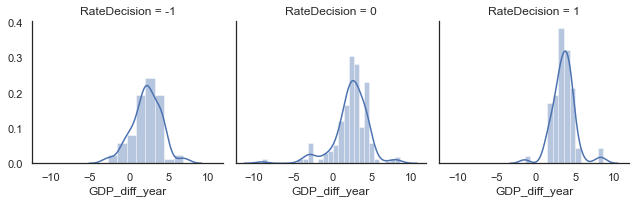

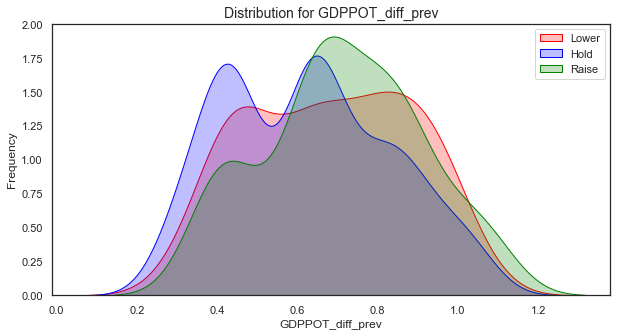

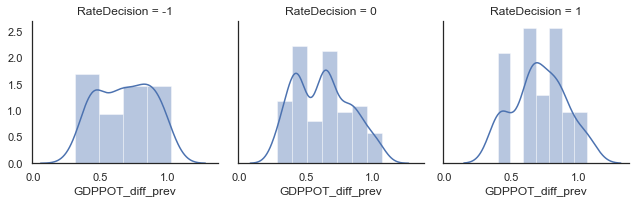

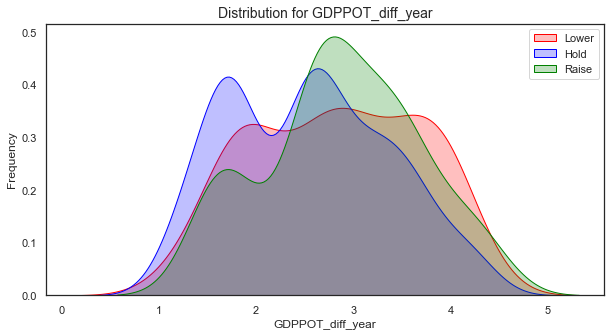

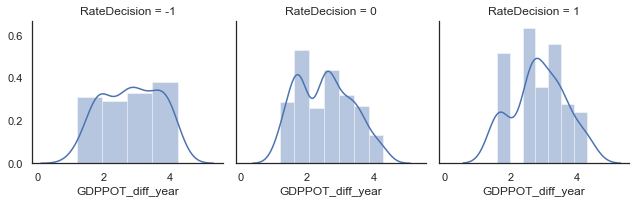

In [16]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

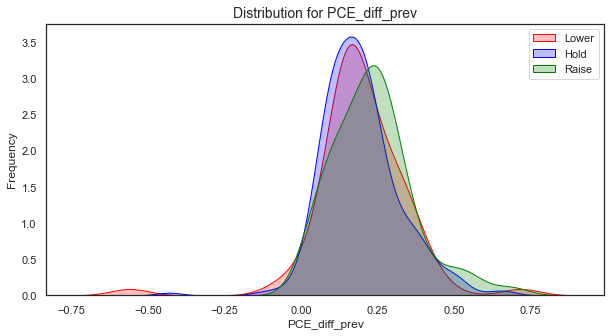

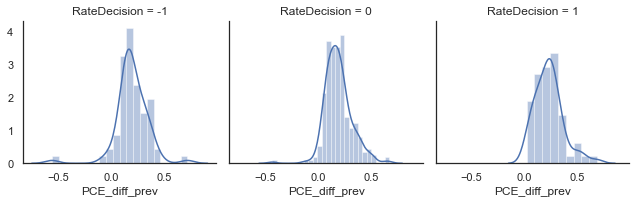

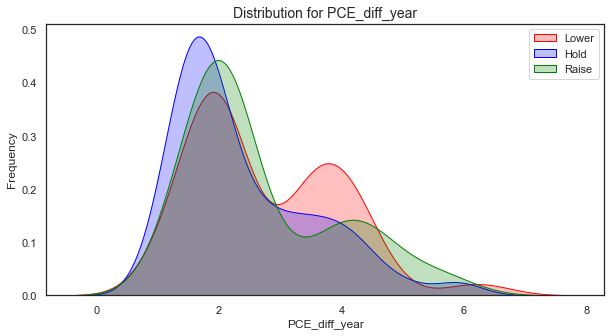

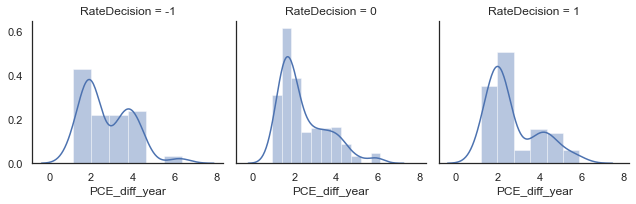

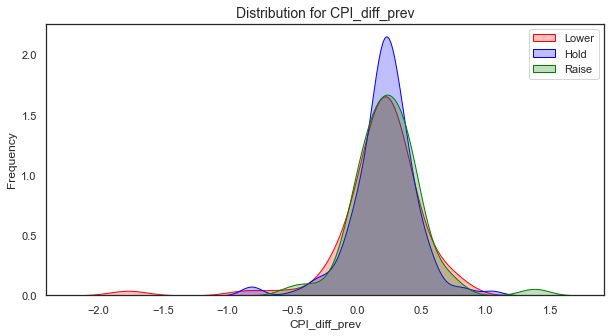

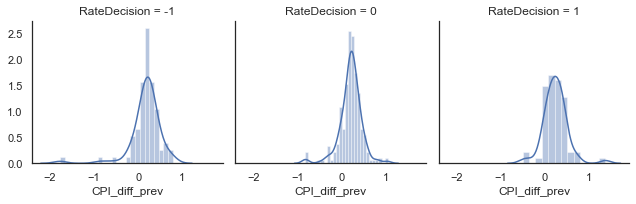

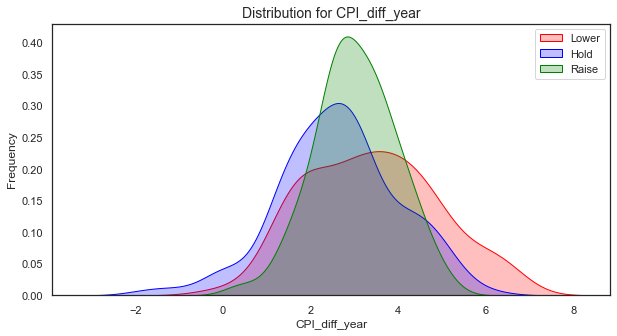

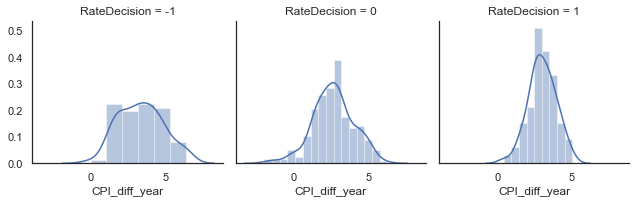

In [17]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

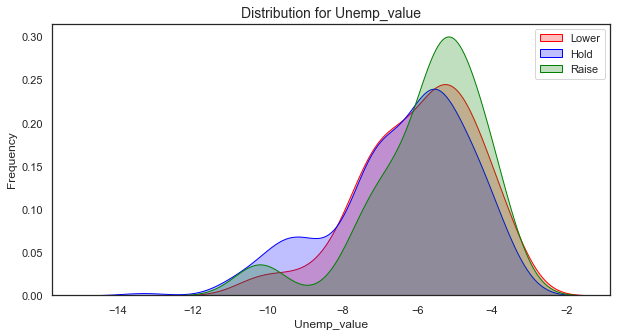

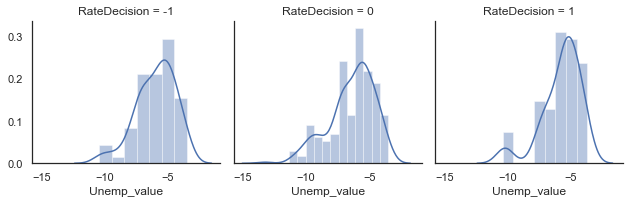

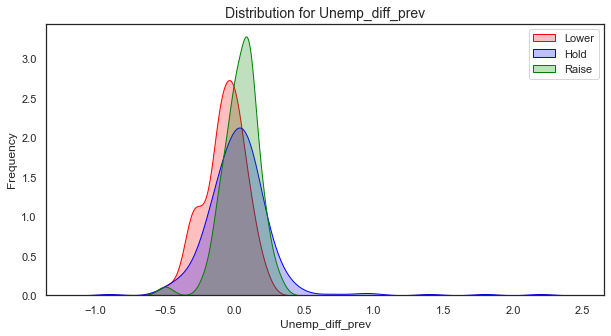

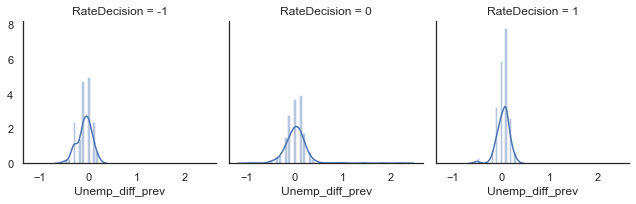

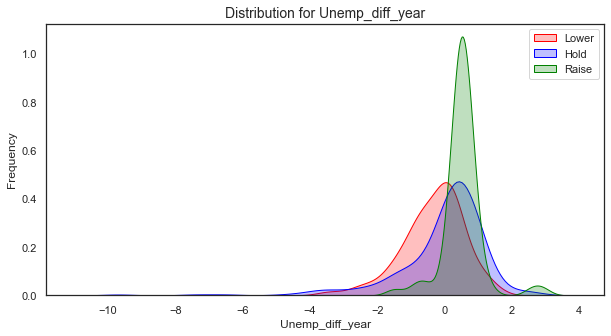

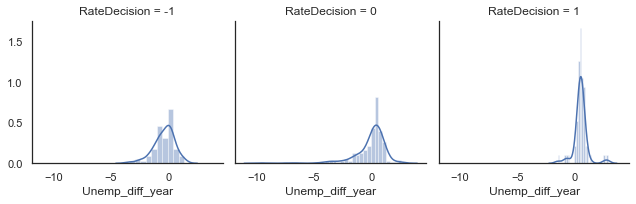

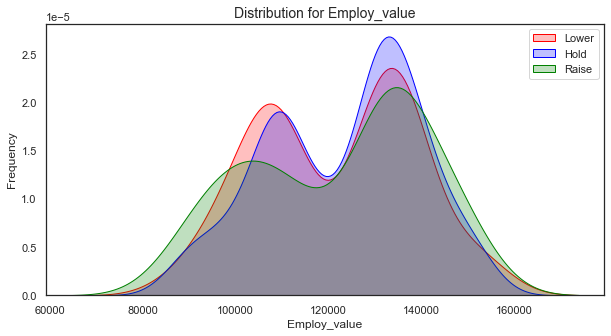

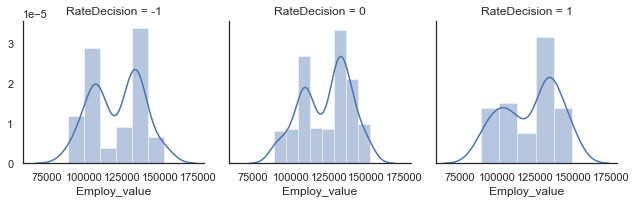

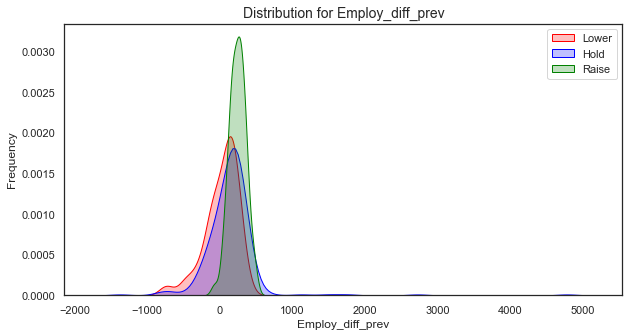

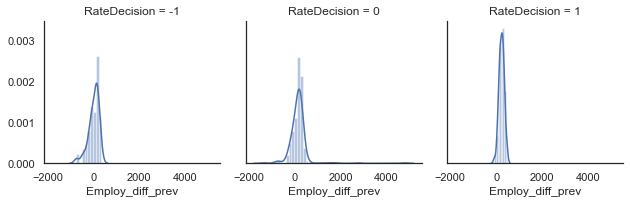

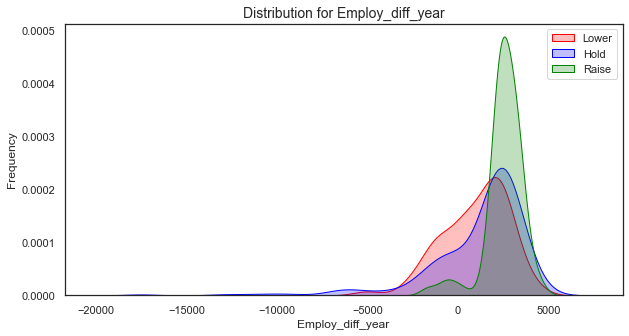

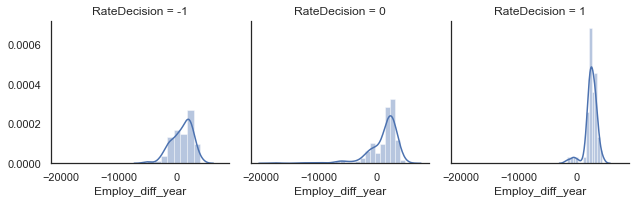

In [18]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

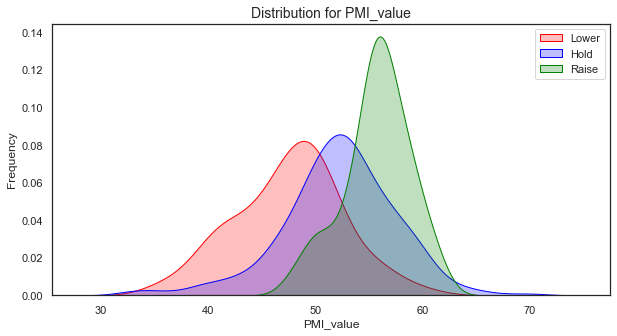

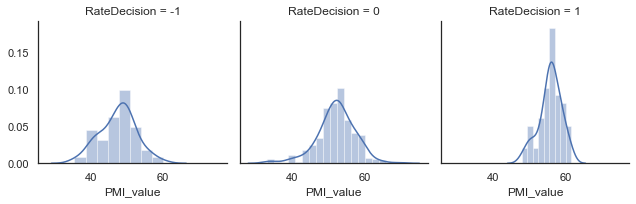

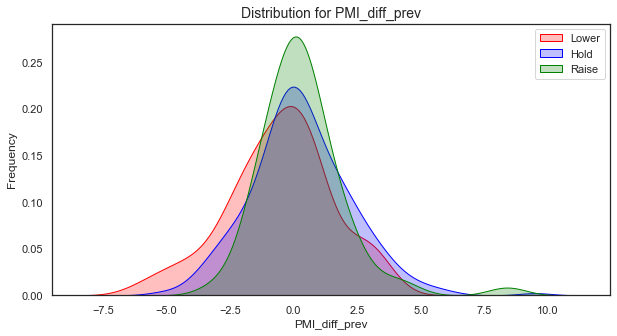

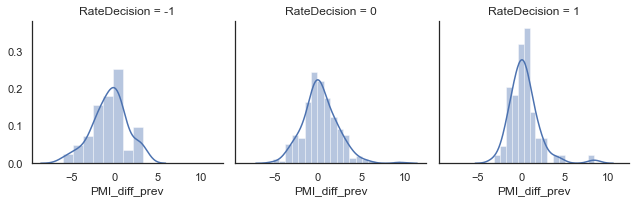

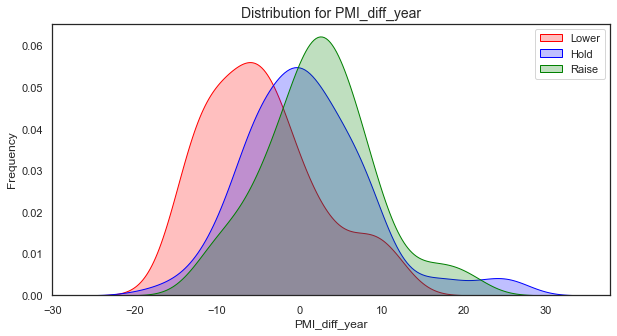

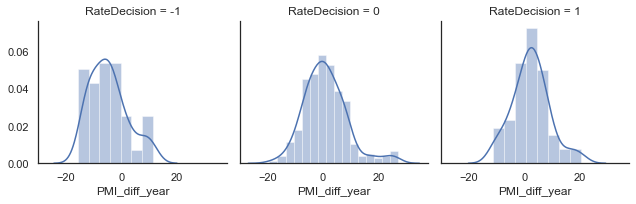

In [19]:
plot_distribution(nontext_data, ["PMI_value", "PMI_diff_prev", "PMI_diff_year"])

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

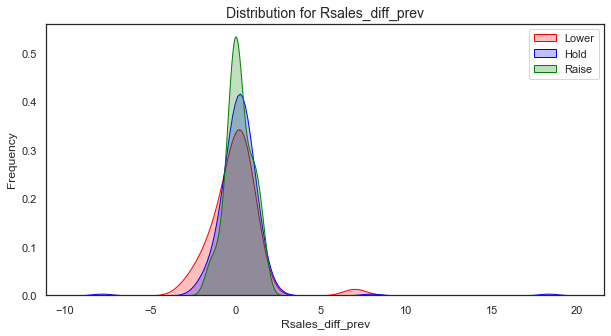

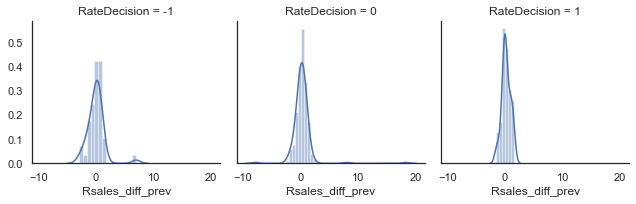

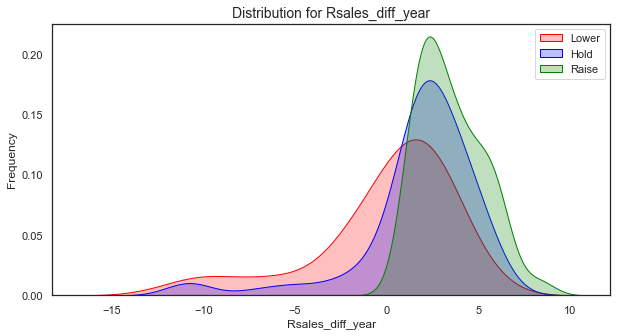

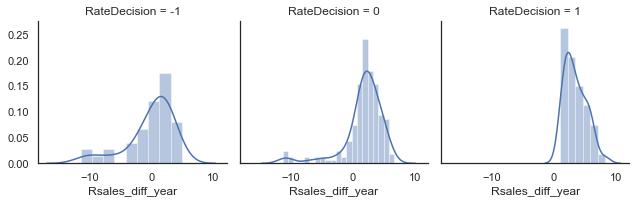

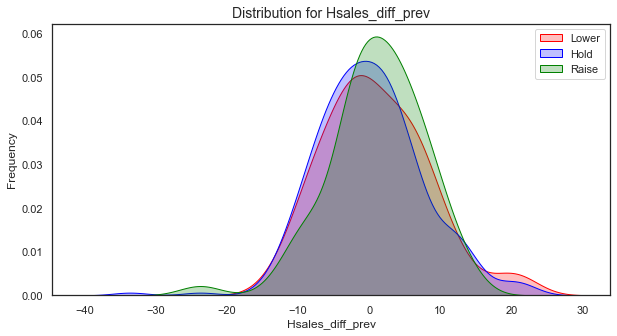

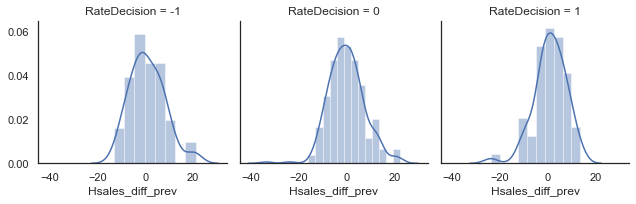

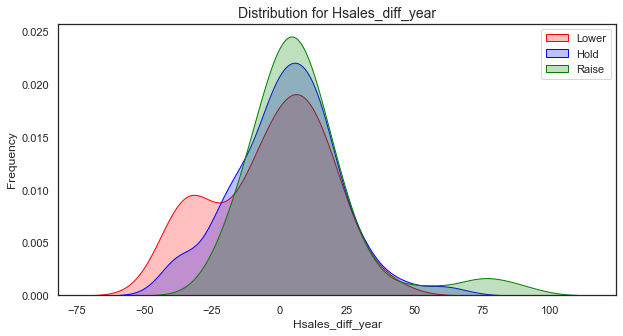

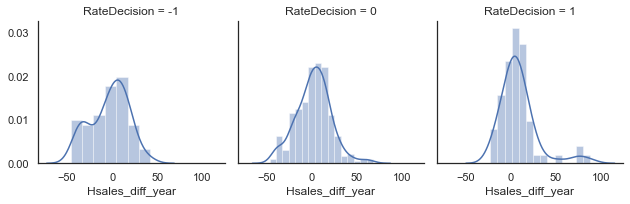

In [20]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

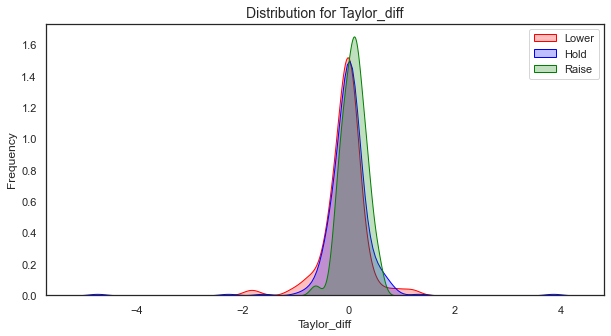

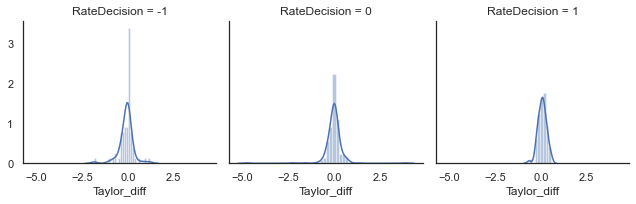

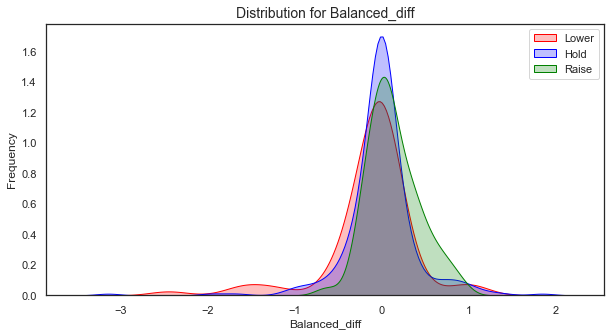

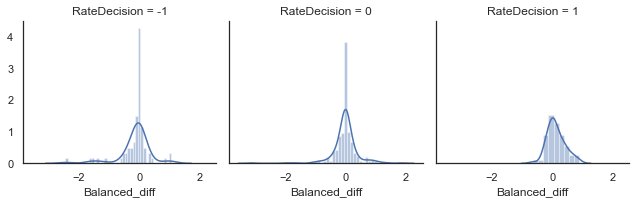

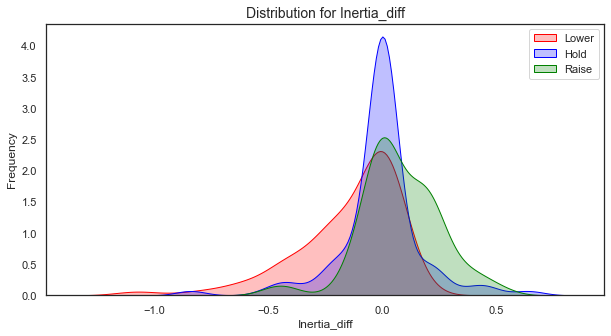

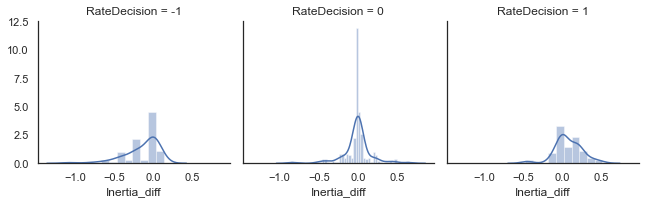

In [21]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

## Create Training Data Set

In [22]:
nontext_train_small = pd.concat([nontext_data[['RateDecision', 'prev_decision', 'GDP_diff_prev', 'PMI_value']],
                                 nontext_ma2[['Employ_diff_prev', 'Rsales_diff_year']], 
                                 nontext_ma3[['Unemp_diff_prev', 'Inertia_diff']], 
                                 nontext_ma12[['Hsales_diff_year', 'Balanced_diff']]], axis=1)
nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

In [23]:
nontext_train_small.isnull().sum()

target                0
prev_decision         1
GDP_diff_prev         0
PMI_value             0
Employ_diff_prev      0
Rsales_diff_year    131
Unemp_diff_prev       0
Inertia_diff          4
Hsales_diff_year      0
Balanced_diff        15
dtype: int64

In [24]:
# Large dataset to include all the latest figures plus 3 months rolling average

latest_columns = ['RateDecision', 'prev_decision',
                  'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

ma3_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
               'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
               'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
               'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
               'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
               'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
               'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

(403, 29)
(403, 27)
(403, 56)


In [25]:
nontext_train_large.isnull().sum()

target                    0
prev_decision             1
GDP_diff_prev             0
GDP_diff_year             0
GDPPOT_diff_prev          0
GDPPOT_diff_year          0
PCE_diff_prev             0
PCE_diff_year             0
CPI_diff_prev             0
CPI_diff_year             0
Unemp_value               0
Unemp_diff_prev           0
Unemp_diff_year           0
Employ_value              0
Employ_diff_prev          0
Employ_diff_year          0
PMI_value                 0
PMI_diff_prev             0
PMI_diff_year             0
Rsales_diff_prev        117
Rsales_diff_year        129
Hsales_diff_prev          0
Hsales_diff_year          0
Taylor-Rate               0
Balanced-Rate             0
Inertia-Rate              0
Taylor_diff               1
Balanced_diff             1
Inertia_diff              1
GDP_diff_prev_ma3         0
GDP_diff_year_ma3         0
GDPPOT_diff_prev_ma3      0
GDPPOT_diff_year_ma3      0
PCE_diff_prev_ma3         0
PCE_diff_year_ma3         0
CPI_diff_prev_ma3   

### Missing Values

In [26]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

(0.0, 400.0)

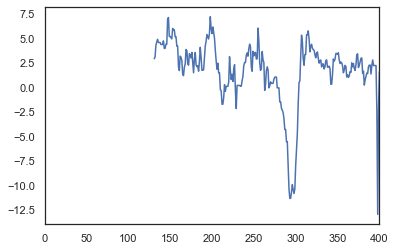

In [27]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

(0.0, 400.0)

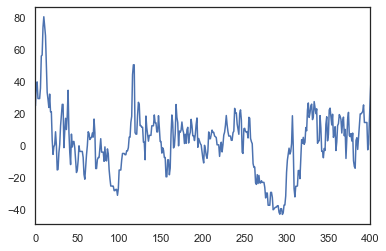

In [28]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [29]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)


In [30]:
nontext_train_small.isnull().sum()

target              0
prev_decision       0
GDP_diff_prev       0
PMI_value           0
Employ_diff_prev    0
Rsales_diff_year    0
Unemp_diff_prev     0
Inertia_diff        0
Hsales_diff_year    0
Balanced_diff       0
dtype: int64

In [31]:
nontext_train_large.isnull().sum()

target                  0
prev_decision           0
GDP_diff_prev           0
GDP_diff_year           0
GDPPOT_diff_prev        0
GDPPOT_diff_year        0
PCE_diff_prev           0
PCE_diff_year           0
CPI_diff_prev           0
CPI_diff_year           0
Unemp_value             0
Unemp_diff_prev         0
Unemp_diff_year         0
Employ_value            0
Employ_diff_prev        0
Employ_diff_year        0
PMI_value               0
PMI_diff_prev           0
PMI_diff_year           0
Rsales_diff_prev        0
Rsales_diff_year        0
Hsales_diff_prev        0
Hsales_diff_year        0
Taylor-Rate             0
Balanced-Rate           0
Inertia-Rate            0
Taylor_diff             0
Balanced_diff           0
Inertia_diff            0
GDP_diff_prev_ma3       0
GDP_diff_year_ma3       0
GDPPOT_diff_prev_ma3    0
GDPPOT_diff_year_ma3    0
PCE_diff_prev_ma3       0
PCE_diff_year_ma3       0
CPI_diff_prev_ma3       0
CPI_diff_year_ma3       0
Unemp_value_ma3         0
Unemp_diff_p

### One-hot encoding

In [32]:
# nontext_train['Lower'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
# nontext_train['Hold'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
# nontext_train['Raise'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
# nontext_train

# Save Data

In [33]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [34]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')